<a href="https://colab.research.google.com/github/kexinwang4483/MLLAB_FINAL/blob/main/wkx_final_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Name (as it appears on Canvas)
----------

Kexin Wang



Research Question / Hypothesis
----

- With the expansion of the Internet, more and more people enjoys reading and sharing online news articles. The number of shares under a news article indicates how popular the news is. In this project, I intend to find the best model and set of feature to predict the popularity of online news, using machine learning techniques. 

- My dataset has 39644 rows, 61 columns and the last column `share` is my target variable. I plan to first decide the threshold and convert it to 2 classes, which would be popular and not popular, so my project is actually a `binary classification` problem.

- The analytic goal include:

1. Convert the target variable to binary format.
2. Preprocess the data appropriately.
3. Fit model for binary classification and check the performance with 2 metrics.
4. Find the best model with grid search and randomized search.
5. Make conclusion.

Load Data
-----

In [1]:

import numpy as np
import pandas as pd
import seaborn as sns
import itertools
import matplotlib.pyplot as plt
from   sklearn.compose            import *
from   sklearn.experimental       import enable_iterative_imputer
from   sklearn.impute             import *
from   sklearn.metrics            import balanced_accuracy_score # Evaluation metric 2.0 
from   sklearn.pipeline           import Pipeline
from   sklearn.preprocessing      import *
from   sklearn.model_selection    import train_test_split
from   sklearn.model_selection    import cross_val_score

from sklearn.base                 import BaseEstimator
from sklearn.decomposition        import PCA
from sklearn.ensemble             import ExtraTreesClassifier, RandomForestClassifier
from sklearn.linear_model         import LogisticRegression, RidgeClassifier
from sklearn.metrics              import f1_score, confusion_matrix,\
    classification_report, precision_recall_curve 
from sklearn.model_selection      import RandomizedSearchCV
from sklearn.neighbors            import KNeighborsClassifier
from sklearn.naive_bayes          import GaussianNB
from sklearn.pipeline             import Pipeline
from sklearn.preprocessing        import StandardScaler
from sklearn.svm                  import LinearSVC
from sklearn.model_selection      import GridSearchCV
import lightgbm as lgb

import warnings
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv('OnlineNewsPopularity.csv', delimiter=',')


In [4]:
cts_col = [' timedelta', ' n_tokens_title', ' n_tokens_content', ' n_unique_tokens',
           ' n_non_stop_words', ' n_non_stop_unique_tokens',
           ' num_hrefs', ' num_self_hrefs', ' num_imgs', ' num_videos',
           ' average_token_length', ' num_keywords', ' kw_min_min', ' kw_max_min', ' kw_avg_min',
           ' kw_min_max', ' kw_max_max', ' kw_avg_max', ' kw_min_avg',
           ' kw_max_avg', ' kw_avg_avg', ' self_reference_min_shares',
           ' self_reference_max_shares', ' self_reference_avg_sharess',
           ' LDA_00', ' LDA_01', ' LDA_02',
           ' LDA_03', ' LDA_04', ' global_subjectivity',
           ' global_sentiment_polarity', ' global_rate_positive_words',
           ' global_rate_negative_words', ' rate_positive_words',
           ' rate_negative_words', ' avg_positive_polarity',
           ' min_positive_polarity', ' max_positive_polarity',
           ' avg_negative_polarity', ' min_negative_polarity',
           ' max_negative_polarity', ' title_subjectivity',
           ' title_sentiment_polarity', ' abs_title_subjectivity',
           ' abs_title_sentiment_polarity']


cat_col = [' data_channel_is_lifestyle',
           ' data_channel_is_entertainment', ' data_channel_is_bus',
           ' data_channel_is_socmed', ' data_channel_is_tech',
           ' data_channel_is_world', ' weekday_is_monday',
           ' weekday_is_tuesday', ' weekday_is_wednesday',
           ' weekday_is_thursday', ' weekday_is_friday',
           ' weekday_is_saturday', ' weekday_is_sunday', ' is_weekend']

# here i skip one column as i don't plan to include that string format feature in this project
drop_col = list(set(df.columns) - set(cts_col) - set(cat_col))


In [5]:
y = df.iloc[:,-1]
x = df.iloc[:, :-1]

In [6]:
# convert target variable into 2 categories
y = np.array(y >= 1400)

In [7]:
x.shape, y.shape

((39644, 60), (39644,))

In [8]:
# check if it is very imbalanced
np.unique(y, return_counts=True)

(array([False,  True]), array([18490, 21154]))

Fit Baseline Model
----

In [9]:
# create a function to convert numeric to categorical
def trans_x(x):
    return x.astype(object)


In [10]:
con_pipe = Pipeline([('scaler', StandardScaler()), 
                     ('imputer', SimpleImputer(strategy='median', add_indicator=True))])

cat_pipe = Pipeline([('convert', FunctionTransformer(trans_x)),
                     ('imputer', SimpleImputer(strategy='constant',
                                               fill_value='Unknown', add_indicator=True)),
                     ('ohe', OneHotEncoder(handle_unknown='ignore'))])
# perform data engineer based on continuous features, categorical featuers and the one I would love to drop
preprocessing = ColumnTransformer([('categorical', cat_pipe, cat_col),
                                   ('continues', con_pipe, cts_col)], 
                                   remainder='drop')

pipe = Pipeline([
    ('prep', preprocessing),
    ('clf', LogisticRegression())
])

In [11]:
# perform train test split with default split
X_train, X_test, y_train, y_test = train_test_split(
    x, y, random_state=999)

In [12]:
# calculate cv score -- f1 weighted
cv_scores = cross_val_score(pipe, X_train, y_train, 
                            scoring='f1_weighted', cv=5)

print(f"Mean CV f1_weighted: {cv_scores.mean():,.4f}")

Mean CV f1_weighted: 0.6519


To evaluate the model, I use cross validation f1 weighted score: 'weighted' calculates the F1 score for each class independently but when it adds them together uses a weight that depends on the number of true labels of each class. I think this is more reasonable to check the model performances. 

I will use the same metric is later steps.

# PCA

I have 45 continuous features and I would like to try reduce the feature dimension.

In [18]:
results = {}
for n_components in range(1, 46):
    pipe = Pipeline([('scaler', StandardScaler()),
                     ('pca',    PCA(n_components=n_components, random_state=42)),
                ])
    pipe.fit(X_train[cts_col]);
    results[n_components] = pipe

In [19]:
explain_res = [] # keep records of the total variance the number of components
for n, pca_current in results.items():
    explained_variance_ratio_ = pca_current['pca'].explained_variance_ratio_
    explain_res.append(sum(explained_variance_ratio_))

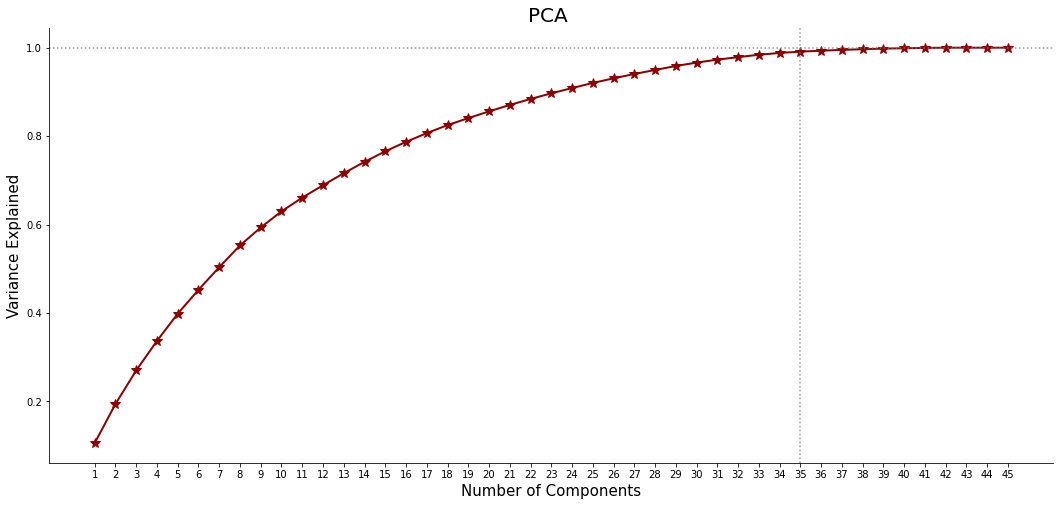

In [20]:
fig, ax = plt.subplots(figsize = (18,8))
ax.plot(explain_res, '-*', color = 'darkred', lw=2, markersize = 10)
ax.axhline(y = 1, linestyle=':', color = 'grey', alpha = 0.8)
ax.axvline(x = 34, linestyle=':', color = 'grey', alpha = 0.8)
ax.set_title("PCA ", size = 20)
ax.set_xticks(np.arange(0, 45))
ax.set_xticklabels([str(i+1) for i in range(45)])
ax.set_xlabel("Number of Components", fontsize = 15)
ax.set_ylabel("Variance Explained", fontsize = 15)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

From the plot I found when the number of components gradually increase over 35, the variance explaied converges, so I would try to keep the number around this range. 

In [21]:
con_pipe2 = Pipeline([('scaler', StandardScaler()),
                     ('imputer', SimpleImputer(strategy='median', add_indicator=True)),
                     ('pca',    PCA(n_components=35, random_state=42))])

cat_pipe = Pipeline([('convert', FunctionTransformer(trans_x)),
                     ('imputer', SimpleImputer(strategy='constant',
                                               fill_value='Unknown', add_indicator=True)),
                     ('ohe', OneHotEncoder(handle_unknown='ignore'))])

preprocessing2 = ColumnTransformer([('categorical', cat_pipe, cat_col),
                                   ('continues', con_pipe2, cts_col)],
                                   remainder='drop')
# update the pipeline with PCA step
pipe2 = Pipeline([
    ('prep', preprocessing2),
    ('clf', LogisticRegression())
])


In [22]:
cv_scores2 = cross_val_score(pipe2, X_train, y_train, 
                            scoring='f1_weighted', cv=5)

print(f"Mean CV f1_weighted: {cv_scores2.mean():,.4f}")

Mean CV f1_weighted: 0.6442


From the result I found both the mean CV f1 score actually drops, but not that much. I know it would be a trade off between model complexicity and the accuracy. I would like a more general model so I would keep PCA and sacrifice accuracy a little bit.

# Grid Search

Before I use Ransomized Search, I would start with the grid search of logistic regression:

In [23]:
n = y_train.shape[0]
indexes = np.random.choice(range(n), int(2* n/3) )
X_gs, y_gs = X_train.iloc[indexes,:], y_train[indexes]

In [24]:
n, X_train.iloc[indexes,:].shape

(29733, (19822, 60))

In [26]:
# grid search on logistic regression
grid_params = dict(clf__penalty=['l1', 'l2'],  # comare 2 penality methods
                  clf__C = np.logspace(0, 4, 10), # different C value for different regularization
                  clf__class_weight = ['balanced', 'None']) # different class weights to solve imbalanced problem (if exists)

gs = GridSearchCV(estimator=pipe2,  
                  param_grid=grid_params,
                  scoring='accuracy',
                  cv=5)

gs.fit(X_gs, y_gs)

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('prep',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='drop',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('categorical',
                                                                         Pipeline(memory=None,
                                                                                  steps=[('convert',
                                                                                          FunctionTransformer(accept_sparse=False,
                                                                                                              check_inverse=True,
               

In [ ]:
gs.best_estimator_.get_params()['clf']

LogisticRegression(C=1.0, class_weight='None', dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
# calculate f1 weighted score with the best estimator
pipe_lg = Pipeline([
    ('prep', preprocessing2),
    ('clf', LogisticRegression(C=1.0, penalty='l2', class_weight='None'))
])


cv_scores_lg = cross_val_score(pipe_lg, X_train, y_train, 
                            scoring='f1_weighted', cv=5)

print(f"Mean CV f1_weighted: {cv_scores_lg.mean():,.4f}")

Mean CV f1_weighted: 0.6442


In [ ]:
# try boosting model 
pipe_lgbm = Pipeline([('prep', preprocessing2),
                     ('clf', lgb.sklearn.LGBMClassifier())])  

# here I mainly search on num_leaves and max_depth, to control the model's complexicity
grid_params2 = dict(
    clf__objective=['binary'],
    clf__boosting_type=['gbdt'],
    clf__learning_rate=[0.3],
    clf__num_leaves=[300, 350, 250],
    clf__max_depth=[200, 150, 250])


gs2 = GridSearchCV(estimator=pipe_lgbm,
                   param_grid=grid_params2,
                   scoring='accuracy',
                   cv=5)

gs2.fit(X_gs, y_gs)

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('prep',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='drop',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('categorical',
                                                                         Pipeline(memory=None,
                                                                                  steps=[('convert',
                                                                                          FunctionTransformer(accept_sparse=False,
                                                                                                              check_inverse=True,
               

In [ ]:
gs2.best_estimator_.get_params()['clf']

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.3, max_depth=200,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=300, objective='binary',
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [ ]:
pipe_lgbm = Pipeline([
    ('prep', preprocessing2),
    ('clf', lgb.sklearn.LGBMClassifier(learning_rate=0.3, max_depth=200, num_leaves=300,
               objective='binary', boosting_type='gbdt'))
])

cv_scores_lgbm = cross_val_score(pipe_lgbm, X_train, y_train,
                                 scoring='f1_weighted', cv=5)

print(f"Mean CV f1_weighted: {cv_scores_lgbm.mean():,.4f}")

Mean CV f1_weighted: 0.6328


In [ ]:
# grid search on linear support vector machine, since there 2 classes, linear kernel is enough
pipe_svc = Pipeline([('prep', preprocessing2),
                     ('clf', LinearSVC())])  

grid_params = dict(clf__penalty=['l1', 'l2'], # how to penalize the model
                  clf__C = np.logspace(0, 4, 10), # how to do regularization
                  clf__class_weight = ['balanced', 'None'], # different class weight to solve imbalanced problem (if exists)
                  clf__max_iter = [1000, 2000, 3000]) # add another search space on max_iter, 
                                                      # how many iterations does it need to converge 

gs3 = GridSearchCV(estimator=pipe_svc,  
                  param_grid=grid_params,
                  scoring='accuracy',
                  cv=5)

gs3.fit(X_gs, y_gs)

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('prep',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='drop',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('categorical',
                                                                         Pipeline(memory=None,
                                                                                  steps=[('convert',
                                                                                          FunctionTransformer(accept_sparse=False,
                                                                                                              check_inverse=True,
               

In [ ]:
gs3.best_estimator_.get_params()['clf']

LinearSVC(C=1.0, class_weight='balanced', dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

In [ ]:
pipe_svc = Pipeline([('prep', preprocessing2),
                     ('clf', LinearSVC(C=1.0, class_weight='balanced', penalty='l2', max_iter=1000))])  
cv_scores_svc= cross_val_score(pipe_svc, X_train, y_train,
                                 scoring='f1_weighted', cv=5)

print(f"Mean CV f1_weighted: {cv_scores_svc.mean():,.4f}")

Mean CV f1_weighted: 0.6451


In [ ]:
# try search for extratree classifier
pipe_et = Pipeline([('prep', preprocessing2),
                     ('clf', ExtraTreesClassifier())])


grid_params = dict(
    clf__class_weight = ['balanced', 'balanced_subsample'], #  class weight
    clf__min_samples_leaf=[1,2], # min sample leaf to control the model complexicity
    clf__max_depth=[50, 200]) # max depth to control the model complexicity

gs4 = GridSearchCV(estimator=pipe_et,  
                  param_grid=grid_params,
                  scoring='accuracy',
                  cv=5)

gs4.fit(X_gs, y_gs)

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('prep',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='drop',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('categorical',
                                                                         Pipeline(memory=None,
                                                                                  steps=[('convert',
                                                                                          FunctionTransformer(accept_sparse=False,
                                                                                                              check_inverse=True,
               

In [ ]:
gs4.best_estimator_.get_params()['clf']

ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight='balanced',
                     criterion='gini', max_depth=200, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=2, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=100,
                     n_jobs=None, oob_score=False, random_state=None, verbose=0,
                     warm_start=False)

In [ ]:
pipe_et = Pipeline([('prep', preprocessing2),
                    ('clf', ExtraTreesClassifier(class_weight='balanced', min_samples_leaf=2, max_depth=200))])
cv_scores_et = cross_val_score(pipe_et, X_train, y_train,
                               scoring='f1_weighted', cv=5)

print(f"Mean CV f1_weighted: {cv_scores_et.mean():,.4f}")

Mean CV f1_weighted: 0.6464


In [ ]:
# try search for random forest
pipe_rf = Pipeline([('prep', preprocessing2),
                     ('clf', RandomForestClassifier())])


grid_params = dict(clf__n_estimators = [50,100,150,200], # how many trees in random forest
                  clf__max_features = ['sqrt', 'log2'], # number of features to consider when looking for the best split
                  clf__min_samples_split = [2,10,20]) # minimum number of samples required to be at a leaf node

gs5 = GridSearchCV(estimator=pipe_rf,  
                  param_grid=grid_params,
                  scoring='accuracy',
                  cv=5)

gs5.fit(X_gs, y_gs)

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('prep',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='drop',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('categorical',
                                                                         Pipeline(memory=None,
                                                                                  steps=[('convert',
                                                                                          FunctionTransformer(accept_sparse=False,
                                                                                                              check_inverse=True,
               

In [ ]:
gs5.best_estimator_.get_params()['clf']

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [ ]:
pipe_rf = Pipeline([('prep', preprocessing2),
                    ('clf', RandomForestClassifier(max_features='sqrt', min_samples_split=2,
                                                   n_estimators=200))])
cv_scores_rf = cross_val_score(pipe_rf, X_train, y_train,
                               scoring='f1_weighted', cv=5)

print(f"Mean CV f1_weighted: {cv_scores_rf.mean():,.4f}")

Mean CV f1_weighted: 0.6509


# Randomized Search CV

In [ ]:
class DummyEstimator(BaseEstimator):
    "Pass through class, methods are present but do nothing."

    def fit(self): pass
    def score(self): pass


pipe_search = Pipeline([
    ('prep', preprocessing2),
    ('clf', DummyEstimator())
])

search = [
    {
        'clf': [LogisticRegression(class_weight='balanced')],
        'clf__C': np.logspace(0, 4, 10)  # mainly interested in the regularization
    },
    {
        'clf': [(lgb.sklearn.LGBMClassifier(objective='binary'))],
        'clf__learning_rate': [0.1, 0.3, 1] # how aggressive the model should learn
    },
    {
        'clf': [RandomForestClassifier()],
        'clf__n_estimators': range(50, 400, 50), # how many trees in random forest, just update the search range to get better results
        'clf__max_features': ['auto', 'sqrt', 'log2'] # number of features to consider when looking for the best split
    },
    {
        'clf': [ExtraTreesClassifier()],
        'clf__max_features': ['auto', 'sqrt', 'log2'], # similiar to grid search
        'clf__class_weight': ['balanced', 'balanced_subsample'] # adjust class weight assigned for each class, make result better
    },
    {
        'clf': [LinearSVC(class_weight='balanced')],
        'clf__C': np.logspace(0, 4, 10) # mainly interested in the regularization
    }
]

clf_algos_rand = RandomizedSearchCV(estimator=pipe_search,
                                    param_distributions=search,
                                    n_iter=15,
                                    cv=5,
                                    n_jobs=-1,
                                    verbose=1)

In [ ]:

clf_algos_rand.fit(X_train, y_train)

clf_algos_rand.best_estimator_

Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:  7.7min finished


Pipeline(memory=None,
         steps=[('prep',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('categorical',
                                                  Pipeline(memory=None,
                                                           steps=[('convert',
                                                                   FunctionTransformer(accept_sparse=False,
                                                                                       check_inverse=True,
                                                                                       func=<function trans_x at 0x7f9f89524320>,
                                                                                       inv_kw_args=None,
                                                                                       inverse_func=None

In [ ]:
clf_algos_rand.best_estimator_.get_params()['clf'] # best model

In [ ]:
pipe3 = Pipeline([
    ('prep', preprocessing2),
    ('clf', RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=None, max_features='sqrt',
                                        max_leaf_nodes=None, max_samples=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=1, min_samples_split=2,
                                        min_weight_fraction_leaf=0.0,
                                        n_estimators=300, n_jobs=None,
                                        oob_score=False, random_state=None,
                                        verbose=0, warm_start=False))
])


cv_scores3 = cross_val_score(pipe3, X_train, y_train, 
                            scoring='f1_weighted', cv=5)

In [ ]:
print(f"Mean CV f1_weighted: {cv_scores3.mean():,.4f}")

Mean CV f1_weighted: 0.6523


# Result/Conclusion 

- Then I would apply my final model on the test data and use the same metric to evaluate - F1 weigthed cv score. 
- As instructed by the professor, I only use test data after I get my final model and I never used it in my previous training and model selection.

In [ ]:
cv_scores_valid = cross_val_score(pipe3, X_test, y_test,
                                  scoring='f1_weighted', cv=5)

print(f"Mean CV f1_weighted: {cv_scores_valid.mean():,.4f}")

Mean CV f1_weighted: 0.6469


- except for f1 weighted score, I would plot the normalized confusion matrix which has been used widely in classification problem. Both the precision and recall are satisfactory as the upper left and lower right corner are darker.

In [ ]:
pipe3.fit(X_train, y_train)
y_pred = pipe3.predict(X_test)
mat = confusion_matrix(y_test, y_pred)

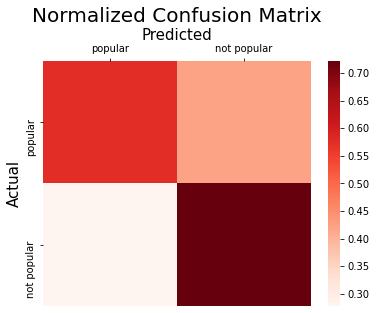

In [ ]:
def normalize(mat):
    """Convert confusion matrix values to percentages (recall)."""
    return mat / mat.sum(axis=1).reshape(-1, 1)
labels = ['popular', 'not popular']
fig, ax = plt.subplots(figsize=(6, 4.5))
sns.heatmap(normalize(mat), cmap='Reds', ax=ax)
plt.xlabel('Predicted', size=15)
plt.ylabel('Actual', size=15)
plt.xticks(ticks=np.arange(0.5, len(labels)+0.5), labels=labels)
plt.yticks(ticks=np.arange(0.5, len(labels)+0.5), labels=labels)
ax.xaxis.set_ticks_position('top')
ax.xaxis.set_label_position('top')
ax.set_title('Normalized Confusion Matrix', fontsize = 20)
plt.show()

## Final model display

- Visually displayed single, best final model
- Display all pipelines steps and all non-default hyperparameters
- Display final model parameters

In [ ]:
pipe3

Pipeline(memory=None,
         steps=[('prep',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('categorical',
                                                  Pipeline(memory=None,
                                                           steps=[('convert',
                                                                   FunctionTransformer(accept_sparse=False,
                                                                                       check_inverse=True,
                                                                                       func=<function trans_x at 0x7f9f89524320>,
                                                                                       inv_kw_args=None,
                                                                                       inverse_func=None

In [ ]:
pipe3.get_params()['steps']

[('prep',
  ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
                    transformer_weights=None,
                    transformers=[('categorical',
                                   Pipeline(memory=None,
                                            steps=[('convert',
                                                    FunctionTransformer(accept_sparse=False,
                                                                        check_inverse=True,
                                                                        func=<function trans_x at 0x7f9f89524320>,
                                                                        inv_kw_args=None,
                                                                        inverse_func=None,
                                                                        kw_args=None,
                                                                        validate=False)),
                                            

In [ ]:
pipe3.get_params()['clf']

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=300,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

## Intepretation

- Explained why things worked (or didn't work)

I am not surperised that Random Forest performs the best, since:

1. Compared with Logistic, Linear SVC, LGBMClassifier, Random Forest use the ensemble method which composed of multiple trees and use majority vote to make final decision. The magic of improved performance is often the reduction in the variance of predicted errors made by its contributing models.   

2. Compared with ExtraTreeClassifier, Random Forest use bootstrap replica but ExtraTree use the original whole data, so ExtraTree may get higher variance. Besides, Random Forest choose best split to minimize loss while ExtraTree use random value. Therefore ExtraTree add randomization.    

3. Although the f1 weighted score of my final pipeline doesn't increase too much. But consider when the dataset size becomes larger, a small increase can be a great progress as well.   

4. Another thing I want to mention is why I choose to keep PCA step. I think this step can be skipped when other people use my pipeline if they want to get higher accuracy, or they want to look at the feature importance. In my case, I would like to get a lower dimension feature space so it is inevitable to lose some information.    


- Connection to business outcome. Answers "Why does this matter?"

In the recent decades, online news became a new popular source for people to obtain news, and for most of the times, people would only focus on the hot topics. Also, reading and sharing news have become the center of people’s entertainment lives. If we could predict the popularity of news prior to its publication, it would be valuable for social media companies, also some authors and advertisers. They can have a prior understanding on what kind of news will receive more clicks, then they can make certain changes on the news' content to make it more popular.   


- List of next steps / future directions

1. Except for LGBMClassifier, there are other boosting models I can try, such as XGBoosting, AdaBoost. Besides, stacking can be another model choice.
2. I believe there is still a large room on feature selection. In the future, it would be interesting to consider add some interaction terms, or other information from some other datasets. For example, I could directly treat all the words in an article as additional features, and then apply machine learning algorithms like Naive Bayes. Combination of the NLP analysis and my pipeline would help.